# Making predictions on the reference dataset
In this notebook, we'll demonstrate using a trained and fine-tuned CNN to make predictions on an independent test set composed of reference isolates. This code illustrates the procedure used to generate the results shown in Figure 2.

## Loading data
The first step is to lad the test dataset.

In [1]:
from time import time
t00 = time()
import numpy as np

In [2]:
X_fn = 'C:/Users/Lenovo/Downloads/data/X_test.npy'
y_fn = 'C:/Users/Lenovo/Downloads/data/y_test.npy'
X = np.load(X_fn)
y = np.load(y_fn)
print(X.shape, y.shape)

(3000, 1000) (3000,)


## Loading trained CNN
Now we set up a ResNET CNN and load weights that we previously trained using the training dataset and fine-tuned using the fine-tuning dataset. We will use this trained model to make predictions on the test dataset.

In [3]:
from resnet import ResNet
import os
import torch

In [4]:
# CNN parameters
layers = 6
hidden_size = 100
block_size = 2
hidden_sizes = [hidden_size] * layers
num_blocks = [block_size] * layers
input_dim = 1000
in_channels = 64
n_classes = 30
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()

In [5]:
# Load trained weights
cnn = ResNet(hidden_sizes, num_blocks, input_dim,
            in_channels=in_channels, n_classes=n_classes)

if cuda: cnn.cuda()
cnn.load_state_dict(torch.load(
    './finetuned_model.ckpt', map_location=lambda storage, loc: storage))

<All keys matched successfully>

## Making predictions
Her we use the trained model to make predictions, and the report the accuracy per isolate. This number should be close to the 82.2% reported in Figure 2, but will not be exactly the the same due to the random sampling of the fine-tune dataset during fine-tuning.

In [6]:
from training import get_predictions
from datasets import spectral_dataloader

In [7]:
# Make predictions on subset of data
t0 = time()
dl = spectral_dataloader(X, y, batch_size=10, shuffle=False)
y_hat = get_predictions(cnn, dl, cuda)
print('Predicted {} spectra: {:0.2f}s'.format(len(y_hat), time()-t0))

Predicted 3000 spectra: 82.66s


In [8]:
# Computing accuracy
acc = (y_hat == y).mean()
print('Accuracy: {:0.1f}%'.format(100*acc))

Accuracy: 82.5%


## Plotting confusion matrix (Figure 2)
We use the predictions to plot a version of the confusion matrix see in Figure 2 of the paper. Each row represents the true class and each columen represents the predicted class. The entries of the confusion matrix are normalized so that the rows sum to 100% (differences from rounding). The accuracy for each class can be seen in the diagonal entries.

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from config import ORDER, STRAINS
%matplotlib inline

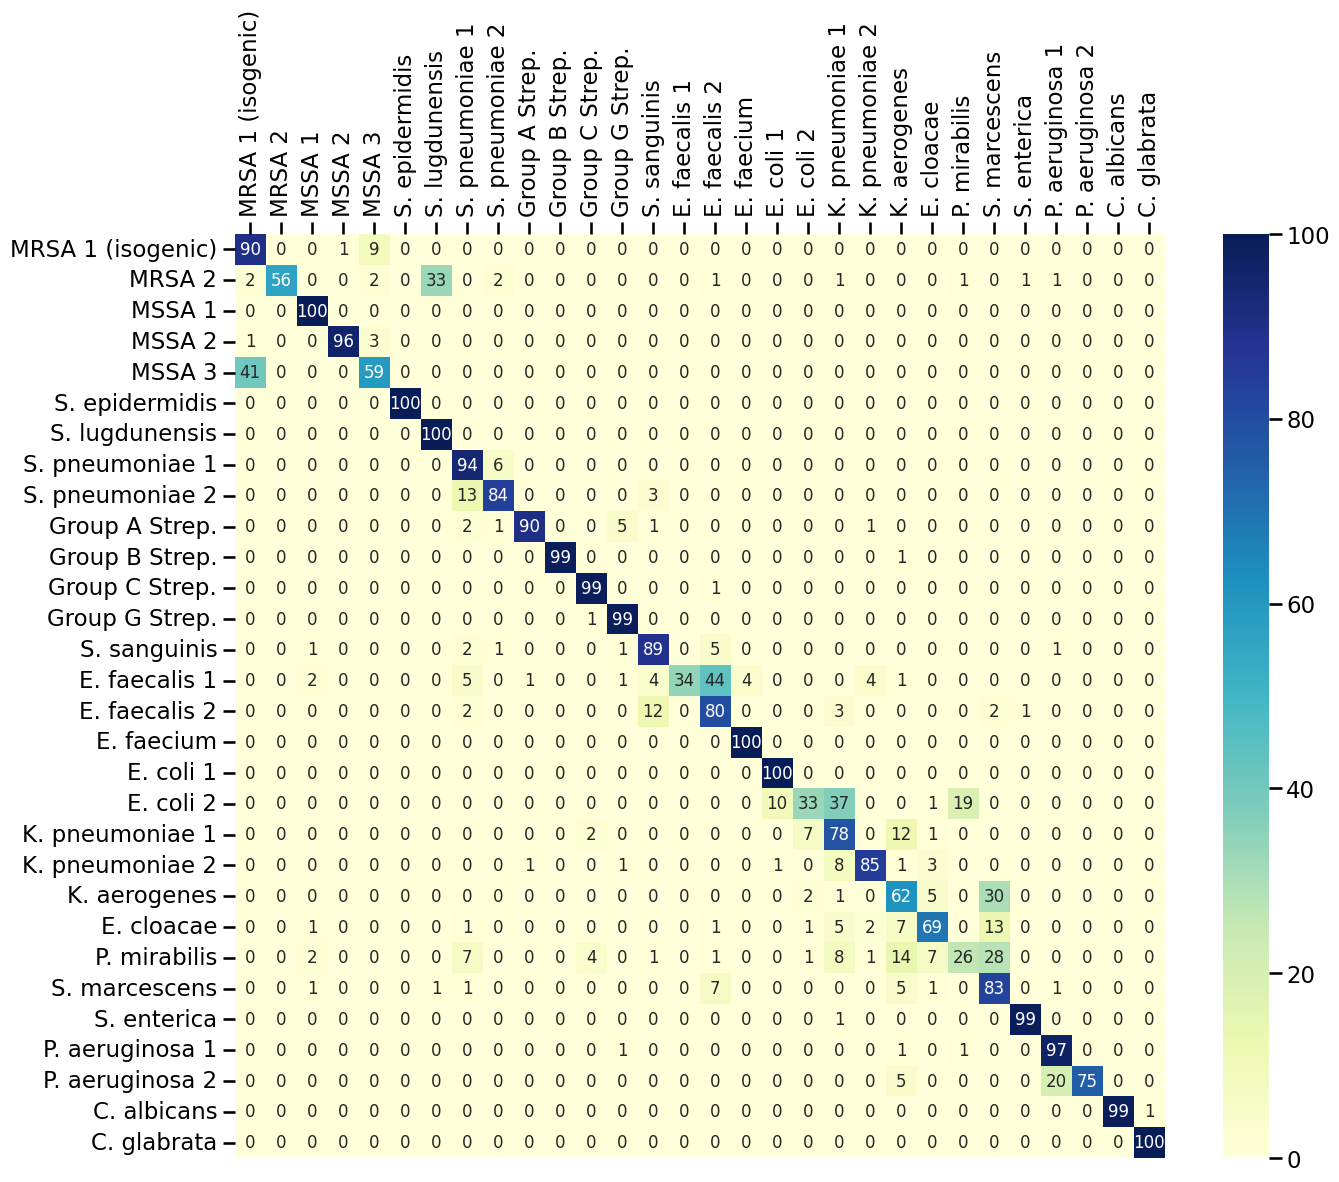

In [13]:
# Plot confusion matrix
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [STRAINS[i] for i in ORDER]
cm = confusion_matrix(y, y_hat, labels=ORDER)
plt.figure(figsize=(15, 12))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.savefig('pyplot.png')
plt.show()

## Plotting confusion matrix for antibiotic groupings
Finally, we can combine predictions into antibiotic groupings to estimate treatment accuracy. The entries of the confusion matrix are normalized so that the rows sum to 100% (differences from rounding). The accuracy for each antibiotic group can be seen in the diagonal entries.

In [11]:
from config import ATCC_GROUPINGS, antibiotics, ab_order

In [12]:
# Mapping predictions into antibiotic groupings
y_ab = np.asarray([ATCC_GROUPINGS[i] for i in y])
y_ab_hat = np.asarray([ATCC_GROUPINGS[i] for i in y_hat])

# Computing accuracy
acc = (y_ab_hat == y_ab).mean()
print('Accuracy: {:0.1f}%'.format(100*acc))

Accuracy: 97.1%


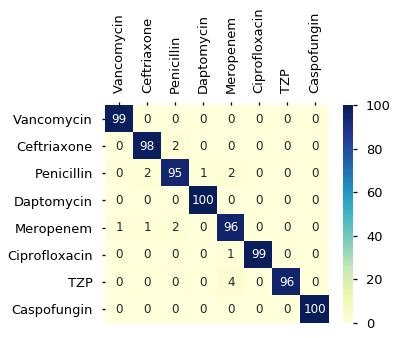


 This demo was completed in: 85.58s


In [13]:
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [antibiotics[i] for i in ab_order]
cm = confusion_matrix(y_ab, y_ab_hat, labels=ab_order)
plt.figure(figsize=(5, 4))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

print('\n This demo was completed in: {:0.2f}s'.format(time()-t00))

The procedures demonstrated here and in the fine-tuning notebook can be readily adapted to the binary classification task between MRSA and MSSA reference isolates to produce the results shown in Figure 3.